In [6]:
import numpy as np 
import matplotlib.pyplot as plt  
import os

from dev import SRM, InputTrain, Synapse, Network, Monitor
from plotting import plot_input

In [2]:
# pretty print matrix A
def pprint(A, precision=3):
    A = np.around(A, decimals=precision)
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA) +' '*(w1-len(str(AAA))+1),end='') # str(AAA)
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='') # str(AA[-1])
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

## Generate new data

In [3]:
from InputGenerator import InputGenerator
# In order to change the hyperparameters of Input spike train change the hyperparameter.yml file.
# input_generator = InputGenerator("hyperparameters.yml")
# input_generator.generate_input_data()

## Reading sample data

In [3]:
input_folder = "input-data-newmodel"
times = np.load(os.path.join(input_folder, "times.npy"))
indices = np.load(os.path.join(input_folder, "indices.npy"))
times_pattern = np.load(os.path.join(input_folder, "times_pattern.npy"))
indices_pattern = np.load(os.path.join(input_folder, "indices_pattern.npy"))
position_copypaste = np.load(os.path.join(input_folder, "position_copypaste.npy"))

In [4]:
# sparse_spike_train = sparse.load_npz(os.path.join(input_folder, "sparse_spike_train.npz"))
# spike_train = sparse_spike_train.toarray()
# pattern_times = list(np.load(os.path.join(input_folder, "pattern_times.npy")))

## Creating Neurons, Synapses, Learning Rule, Network

In [3]:
from typing import Iterable, Optional
import numpy

some notes for my own development:
- for now all the initialization parameters are None, you can change to some default values in the future.

- Pay attention to register_buffer for some of the parameters in the model. The ones which do not need to be trained but are needed to save in `state_dict`. When moving the code to Pytorch maybe!

- Change the SRM class so that it can accept np.array for hyperparameters, this way each postsynaptic neuron can have different hyperparameters

- 

In [4]:
## so the idea is that write these variables in a py file and then
## import them in the notebook/py file and use them to initialize the objects
DEFAULT_DT = 0.001
dt = DEFAULT_DT

In [49]:
class SRM():
    def __init__(
            self, 
            N: int = None,
            threshold: float = None,
            reset: float = None,
            refractory: float = None, # refractory is a float time [second]
            tau_m: float = None,
            tau_s: float = None,
            K1: float = None,
            K2: float = None,
            window_time: float = None, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode: bool = True
        ) -> None:
        """
        """
        assert N is not None, "Number of neurons must be provided." # TODO: write better check for the class 

        self.N = N
        self.threshold = threshold
        self.reset = reset
        self.refractory = refractory
        self.ref_counter = np.zeros((self.N,1))
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.window_time = window_time
        self.train_mode = train_mode
        ## TODO: Do I need to tell the model about dt? dt should be given by user in net = Networ()
        self.dt = DEFAULT_DT
        ## TODO: I think we need to keep track of current time (t).
        ## TODO: Updating self.t will occur inside the net = Network? 
        # self.t = None
        self.last_spike_time = - np.ones((self.N,1)) * np.inf

        self.potential_rec = None
        self.monitor = None
    
            
    def forward(self, spikes_t: numpy.array, w_tmp: numpy.array, current_t: float, current_it, i: int):
        """
        spikes_t here is a correct window of spikes_t.
        tmp_w is the corresponding weights of spikes_t.
        current_t is ms 
        """
        # There's an input
        # TODO: maybe I can check if spikes_t is not empty before calling forward()
        if len(spikes_t) != 0:

            s = current_t + self.dt - spikes_t
            eps = self.eps_kernel(s)
            eps = eps * w_tmp
            # eps = eps.reshape((self.N,-1))
            # print(s)
            # pprint(w_tmp)
            # pprint(eps)
            # print(eps.shape)
            # eps = eps.sum(axis=1, keepdims=True)
            eps = eps.sum()
            s = current_t + self.dt - self.last_spike_time[i]
            eta = self.eta_kernel(s)
            # TODO: What to do with calculated pot.?
            potential = eta + eps
            # print(f"potential = ")
            # pprint(potential)
            self.potential_rec[i, current_it + 1] = potential.squeeze() # potential.squeeze()
        
        # no incoming input
        else:
            # pst = 0 since we dont have any incoming input train
            eps = 0
            s = current_t + self.dt - self.last_spike_time[i]
            eta = self.eta_kernel(s)
            # TODO: What to do with calculated pot.?
            potential = eta + eps
            self.potential_rec[i, current_it + 1] = potential.squeeze()
            
        
        print(f"{current_t = }")
        print(f"{self.last_spike_time[i] = }")
        print(f"for neuron number = {i}")
        print(f"{eps = }")
        print(f"{eta = }")
        print(f"{potential = }")
        print(f"{current_it + 1 = }")
        print(f"{self.potential_rec[i, current_it + 1] = }")
        print()

        return potential

    def get_potential_i(self,spikes_t: numpy.array, w_tmp: numpy.array, current_t: float, current_it: float, i: int):
        
        potential = self.forward(spikes_t, w_tmp, current_t, current_it, i)

        return potential
    
    
    # def spike_check(self, potential: float):
    #     if potential >= self.threshold:
    #         return True
    #     else:
    #         return False
        
    def check_refractory(self):
        idx = self.ref_counter > 0
        self.ref_counter[idx] -= 1
        self.ref_counter[idx] = np.round(self.ref_counter[idx], 0) 
        return ~idx  

    def start_refractory(self,idx, current_t):
        self.ref_counter[idx] = self.refractory / self.dt
        self.last_spike_time[idx] = current_t
    
    
    def reset_neuron(self,):
        ### what should be reseted exactly?
        self.t = 0
        self.last_spike_time = - np.inf

    def init_records(self, time):
        T = time + 1
        self.potential_rec = np.zeros((self.N, T))
        # if self.monitor:
        #     self.monitor.init_records(time)
    
    
    ## TODO: use compute_k() when adding the layer into the Network()
    def compute_K(self):
        """
        K is chosen such that the maximum value of epsilon kernel will be 1, based on the tau_m and tau_s.
        """
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        self.K = 1 / max_val
            
    def eps_kernel(self, s: numpy.array):
        """"
        s = t - t_j 
        time difference between thre current time and spike time of presynaptic neuron (t_j)
        """
        if not hasattr(self, 'K'):
            self.compute_K()
        return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))

    def eta_kernel(self, s: numpy.array):
        """
        s = t - t_i
        """
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return self.threshold * (positive_pulse - negative_spike_afterpotential)




In [60]:
model = SRM(N=N,
            threshold=threshold,
            reset= reset,
            refractory=refractory, # refractory is a float time [second]
            tau_m=tau_m,
            tau_s=tau_s,
            K1=K1,
            K2=K2,
            window_time= window_time, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= train_mode)

s_max = model.compute_K()
print(s_max)

max_val = (np.exp(-s_max/tau_m) - np.exp(-s_max/tau_s))
print(max_val)
K = 1 / max_val
s = 0.006
K * (np.exp(-s/tau_m) - np.exp(-s/tau_s))

0.0046209812037329686
0.4724703937105774


0.969571191978708

In [56]:
s_max = (tau_m * tau_s) / (tau_s - tau_m) * np.log(tau_s / tau_m)
max_val = (np.exp(-s_max/tau_m) - np.exp(-s_max/tau_s))
print(s_max)
print(max_val)
K = 1 / max_val
s= s_max
K * (np.exp(-s/tau_m) - np.exp(-s/tau_s))

0.0046209812037329686
0.4724703937105774


1.0

In [58]:
current_t = 4 * dt
current_it = 4
spikes_t = np.array([1,  2,  2,  2,  3,  3,  4]) * dt
spikes_i = np.array([0,  0,  1,  2,  1,  2,  2])

weight_example = np.array([[10,11],
                          [20,21],
                          [30,31]], dtype=float)


w_tmp = weight_example[spikes_i,1].squeeze().T
print(w_tmp)
print(w_tmp.shape)
print("***************")



model = SRM(N=2,
            threshold=2.9,
            reset= 0,
            refractory=0.001, # refractory is a float time [second]
            tau_m=0.010,
            tau_s=0.0025,
            K1=2,
            K2=4,
            window_time= 7 * 0.010, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= True )
model.init_records(time=1)

s = current_t + dt - spikes_t
eps =model.eps_kernel(s)
pprint(eps)
eps = eps * w_tmp
pprint(eps)
eps = eps.sum()
print(eps)
s = current_t + dt - model.last_spike_time[1]
eta = model.eta_kernel(s)
pprint(eta)
pot = eta + eps
pprint(pot)
print(pot.shape)

potential_rec = np.zeros((2, 20))
potential_rec[1, int(current_t/dt)] = pot.squeeze()
potential_rec

potential = []
for i in range(2):
    pot = model.get_potential_i(spikes_t, w_tmp, current_t, current_it, i)
    potential.append(pot)

potential = np.array(potential)
pprint(potential)
print(potential.shape)
pprint(model.potential_rec)


[11. 11. 21. 31. 21. 31. 31.]
(7,)
***************
[0.991 0.93  0.93  0.93  0.782 0.782 0.496]
[10.906 10.235 19.54  28.845 16.419 24.237 15.387]
125.56956733937163
[0.]
[125.57]
(1,)
┌────────┐
 [125.57]
 [125.57]
└────────┘
(2, 1)
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [6]:
class InputTrain():
    def __init__(self,
                spikes_t,
                spikes_i) -> None:
        self.spikes_t = spikes_t
        self.spikes_i = spikes_i

class Monitor():
    def __init__(self,
                 layer: SRM) -> None:
        layer.monitor = self
        ## TODO: Is there a way to know how many times each of the postsynaptic neurons will spike?
        self.spikes_t = np.array([])
        self.spikes_i = np.array([])
        ## TODO: Maybe also mode potential_rec to monitor object instead of SRM model itself.
        # self.potential_rec = None
        self.dt = DEFAULT_DT

    def record_spike(self, current_t, idx):
        tmp_t = [current_t] * (idx)
        tmp_t = tmp_t[idx]
        self.spikes_t = np.append(self.spikes_t, tmp_t)
        tmp_i = np.where(idx)[0]
        self.spikes_i = np.append(self.spikes_i, tmp_i)



        


class Synapse():
    def __init__(
                self,
                w: numpy.array,
                w_max: float,
                w_min: float,
                A_pre: float,
                A_post: float,
                tau_pre: float,
                tau_post: float,
                approximate: bool = False
                ) -> None:
        self.w = w
        self.w_max = w_max
        self.w_min = w_min
        self.A_pre = A_pre
        self.A_post = A_post
        self.tau_pre = tau_pre
        self.tau_post = tau_post
        ## if True do nearest spike approximation, else consider all the contributions of the previous presynaptic spikes
        self.approximate = approximate
        
        self.a_pre = np.zeros_like(self.w)
        self.a_post = np.zeros_like(self.w)
        self.dt = DEFAULT_DT
        # self.afferents_spiked = np.zeros((self.w.shape[0],1))

        if self.A_pre < 0:
            raise ValueError("A_pre should be > 0")
        if self.A_post > 0:
            raise ValueError("A_post should be < 0")
        if len(self.w.shape) < 2:
            raise ValueError("w should be 2D")
    
    def get_w_tmp(self, spikes_i: numpy.array, i):
        """
        spikes_i contains only the correct window of spikes_i
        """
        return self.w[spikes_i, i].squeeze().T

    def on_pre(self,idx):
        """
        idx is the index of presynaptic neurons that spiked at the current time and now increasing their a_pre,
        idx is a python list
        """
        if self.approximate:
            self.a_pre[idx, :] = self.A_pre
            # self.a_pre[self.afferents_spiked] += self.A_pre
        else: self.a_pre[idx, :] += self.A_pre
              # self.a_pre[self.afferents_spiked] += self.A_pre
        self.w[idx, :] = np.clip(self.w[idx, :] + self.a_post[idx, :], self.w_min, self.w_max)
        # self.w = np.clip(self.w + self.a_post[self.afferents_spiked], self.w_min, self.w_max)

    def on_post(self, idx):
        """
        idx is the index of postsynaptic neurons not in refractory period and their membrane potential above threshold
        """
        if self.approximate:
            self.a_post[:, idx.squeeze()] = self.A_post
        else: self.a_post[:, idx.squeeze()] += self.A_post
        ## TODO: Only the weights of the postsynaptic neurons that are spiking at the current time should be updated
        self.w[:, idx.squeeze()] = np.clip(self.w[:, idx.squeeze()] + self.a_pre[:, idx.squeeze()], self.w_min, self.w_max)

    def update_a(self):
        self.a_pre = self.a_pre - self.dt / self.tau_pre * self.a_pre
        self.a_post = self.a_post - self.dt / self.tau_post * self.a_post



In [7]:
synapse = Synapse(w=weight_example,
                  w_max=1,
                  w_min=0,
                  A_pre=0.01,
                  A_post=-0.01,
                  tau_pre=0.01,
                  tau_post=0.01,
                  )

synapse.a_post[1,:] = [0.5, -0.5]
synapse.a_post[2,:] = [0.2, 0.6]
synapse.a_pre[0, :] = [-0.4, 10]
potential = np.zeros((3,1))
potential[0,0] = 1.5
potential[1,0] = 1.1

pprint(synapse.a_post)
pprint(synapse.w)
pprint(potential)

idx = model.check_refractory()
idx_spike = potential[idx] >= 1.0
print(idx)
print(idx_spike)

synapse.a_post[idx_spike] += synapse.A_post
pprint(synapse.a_post, precision=4)
synapse.A_post

# synapse.on_post(idx_spike)

# synapse.a_post




# synapse.on_post(idx)
# pprint(synapse.a_post)
# pprint(synapse.w)

NameError: name 'weight_example' is not defined

In [7]:
class NetworkBase():
    def __init__(
            self,
            ) -> None:
        self.synapses = []
        self.layers = []
        self.potential = []
        self.input_train = None
        self.dt = DEFAULT_DT
        self.current_t = 0.0 ## also add in reset()!

    def add_synapse(self, synapse: Synapse):
        self.synapses.append(synapse)
        

    def add_layer(self, layer: SRM):
        self.layers.append(layer)
        self.potential.append(np.zeros((layer.N, 1)))
        
    def add_input_train(self, input_train: InputTrain):
        self.input_train = input_train

    def init_records(self,time):
        # TODO: remove the line below in the future
        # so that we can have multiple net.run() and it considers
        # current time of previous runs!
        self.current_t = 0.0
        self.current_it = 0
        for layer in self.layers:
            layer.init_records(time)


    def check_post_spike(self, layer: SRM, synapse: Synapse, monitor: Monitor, idx: numpy.array):
        """
        idx is the index of the neurons not in refractory period and their membrane potential above threshold
        current_idx = int(current_t/ dt)
        """
    
        synapse.on_post(idx)
        if monitor:
            monitor.record_spike(self.current_t, idx)
        layer.start_refractory(idx, self.current_t)
        layer.potential_rec[idx.squeeze(), self.current_it] = layer.eta_kernel(0.0)
        # TODO: I think line below is unnecessary! as it gets updated each iteration
        # self.potential[idx_spike] = layer.eta_kernel(0.0)
        
        # synapse.afferents_spiked = np.zeros((synapse.w.shape[0],1))


In [43]:
class Network(NetworkBase):
    def __init__(self,):
        super().__init__()
    
    def get_potential(self, layer):
        spikes_t = self.input_train.spikes_t
        spikes_i = self.input_train.spikes_i
        potential = [] 
        for i in range(layer.N):
            
            start_idx = max(0, self.current_t - 7 * layer.tau_m, layer.last_spike_time[i].squeeze())
            start_slice = np.searchsorted(spikes_t, start_idx, side='left')
            end_slice = np.searchsorted(spikes_t, self.current_t, side='right')
            print(f"{start_slice = }, {end_slice = }")
            # update index value
            end_slice = end_slice
            spikes_t_i = spikes_t[start_slice:end_slice]
            spikes_i_i = spikes_i[start_slice:end_slice]
            w_tmp = synapse.get_w_tmp(spikes_i_i, i)
            potential_i = layer.get_potential_i(spikes_t_i, w_tmp, self.current_t, self.current_it, i)
            potential.append(potential_i)
        self.potential = np.array(potential)

    
    def run_one_step(self):
        spikes_t = self.input_train.spikes_t
        spikes_i = self.input_train.spikes_i
        for l, layer in enumerate(self.layers):
            # idx : index of neurons not in refractory period.
            idx = layer.check_refractory()
            idx_spike = self.potential[l] >= layer.threshold
            idx_spike = idx * idx_spike
            self.check_post_spike(layer=layer, synapse=self.synapses[l], monitor=layer.monitor, idx=idx_spike)
            ## WARNING:
            ## TODO: There is a bug here when a deep network is defined.
            ## here istead of a usinng spike_t which is from the InputTrain
            ## we should instead use the spike train from previous layer not the input!
            
            print(f"{self.current_t = }")
            self.get_potential(layer)


            # STDP LTD Rule
            # print(spikes_t)
            idx_right = np.searchsorted(spikes_t, self.current_t, side='right')
            idx_left = np.searchsorted(spikes_t, self.current_t, side='left')
            # print(idx_left, idx_right)
            # pprint(spikes_i[idx_left:idx_right])
            # print(len(spikes_i[idx_left:idx_right]), len(set(spikes_i[idx_left:idx_right])))
            assert len(spikes_i[idx_left:idx_right]) == len(set(spikes_i[idx_left:idx_right])), \
                "At least one neuron is spiking two times at the same time!"
            self.synapses[l].on_pre(spikes_i[idx_left:idx_right])
        
        print("*"*30)
            

    def run(self, time: float):
        """
        time (ms)
        """
        self.init_records(time)
        ## Check the behaviour of + self.dt on the last loop step
        for it in range(time):
            self.current_it = it
            # print(f"{it = }\n")
            self.run_one_step()


            self.current_it = it
            self.current_t += self.dt
            self.current_t = np.round(self.current_t,3)

In [20]:
current_t = 3 * dt
start_slice = 1
pprint(spikes_t)
pprint(spikes_i)
idx_right = np.searchsorted(spikes_t[start_slice:], current_t, side='right')
idx_left = np.searchsorted(spikes_t[start_slice:], current_t, side='left')
print(idx_right)
print(idx_left)
pprint(spikes_t[start_slice + idx_left: start_slice + idx_right])
pprint(spikes_i[start_slice + idx_left: start_slice + idx_right])
# idx = np.searchsorted(spikes_t, it*dt, side='right')

pprint(synapse.a_pre)
print(type(synapse.a_pre))

synapse.a_pre[spikes_i[idx_left:idx_right], :] += synapse.A_pre
pprint(synapse.a_pre)

[0.001 0.002 0.002 0.002 0.003 0.003 0.004]
[0 0 1 2 1 2 2]
5
3
[0.003 0.003]
[1 2]
┌─────────────────┐
 [0.5     -0.5  ]
 [1.938   -9.062]
 [-49.062 20.938]
└─────────────────┘
<class 'numpy.ndarray'>
┌───────────────┐
 [0.5    -0.5 ]
 [2.25   -8.75]
 [-48.75 21.25]
└───────────────┘


## Tests

In [126]:
assert (False and True), "if assert gets Flase then we get an error message!" 

AssertionError: if assert gets Flase then we get an error message!

In [3]:
dt = 0.001

N = 2
threshold = 2.9
reset = 0
refractory = dt
tau_m = 0.010
tau_s = 0.0025
K1 = 2
K2 = 4
window_time= 7 * 0.010, # Maximum time [second] to ignore inputs before it by kernels 
train_mode= True


w_max = 1
w_min = 0
A_pre = 0.3125
B = 0.85 
A_post = - A_pre * B
tau_pre=0.0168
tau_post=0.0337

In [4]:
spikes_t

# last_spike_time = 0.033
last_spike_time = 0.050

start_idx = max(0, last_spike_time)
start_slice = np.searchsorted(spikes_t, start_idx, side='left')
print(spikes_t)
start_slice

NameError: name 'spikes_t' is not defined

In [7]:

spikes_t = np.array([2, 23, 44, 45, 48, 61]) * dt
spikes_i = np.array([0, 0,  1,  2,  1,  2])
weight_example = np.array([[1,1],
                          [1,1],
                          [1,1]], dtype=float)

# weight_example = np.array([[10,11],
#                           [20,21],
#                           [30,31]], dtype=float)

input_train = InputTrain(spikes_t, spikes_i)

model = SRM(N=N,
            threshold=threshold,
            reset= reset,
            refractory=refractory, # refractory is a float time [second]
            tau_m=tau_m,
            tau_s=tau_s,
            K1=K1,
            K2=K2,
            window_time= window_time, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= train_mode)

synapse = Synapse(w=weight_example,
                  w_max=w_max,
                  w_min=w_min,
                  A_pre=A_pre,
                  A_post=A_post,
                  tau_pre=tau_pre,
                  tau_post=tau_post,
                  approximate=False
                  )
monitor = Monitor(model)

net = Network()

net.add_input_train(input_train)
net.add_layer(model)
net.add_synapse(synapse)

# time must be ms
net.run(time=75)

it = 0


In [8]:
synapse.w

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [0.80929358, 0.80929358]])

In [9]:
current_t = 61
print(f"calculating for {current_t+1} ms")
s = (current_t + 1 - 50) * dt
print(model.potential_rec[0,current_t+1])
print(model.eta_kernel(s))

calculating for 62 ms
-1.1550971992979722
-1.6514613633221402


In [10]:
print(model.last_spike_time)
model.potential_rec[0,-10:]
# model.potential_rec[0,60]
# s = (52 + 1 - 50) * dt
# model.eta_kernel(s)

[[0.05]
 [0.05]]


array([-0.34461614, -0.26197691, -0.20363463, -0.16185958, -0.13144368,
       -0.1088717 , -0.09176544, -0.078511  , -0.06800863, -0.05950498])

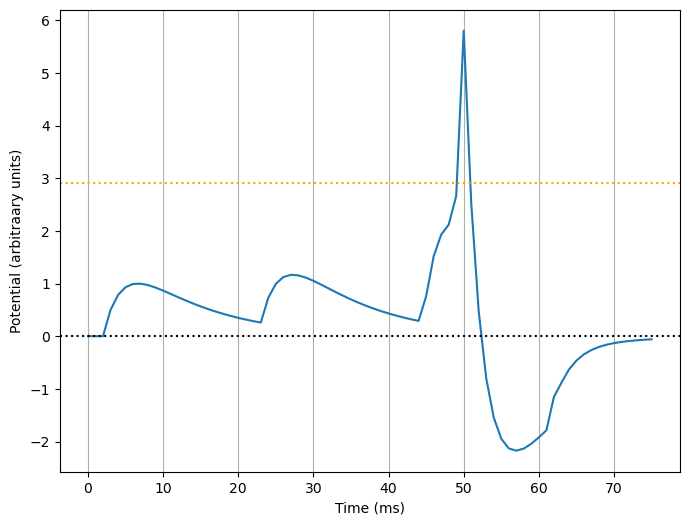

In [11]:
def plot_membrane_potential(potential_rec, threshold):
        plt.figure(figsize=(8,6))
        plt.grid(visible=True, which='major', axis='x')
        # plt.xticks(np.arange(0, len(potential_rec), 1))
        plt.plot(np.arange(0,len(potential_rec),1), potential_rec)
        # spikes = np.where(spike_train ==1)[1]
        # for spk in spikes:
            # plt.axvline(spk, linestyle='-.', color='gray')
        plt.axhline(threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')
        plt.show()

plot_membrane_potential(model.potential_rec[0], 2.9)

In [129]:
model.t = 0 * dt
model.compute_K()
model.last_spike_time = - np.inf
model.dt = dt
for it in range(75):
    model.t = it * dt
    idx = np.searchsorted(spikes_t, it*dt, side='right')
    model.forward(spikes_t[:idx], tmp_w[:idx], current_t= it*dt)

s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
eta = 0.0
s = inf
et

For now given an input at 23 ms it increases the mem. pot. at 24 ms, just as the eta kernel would do in the paper!

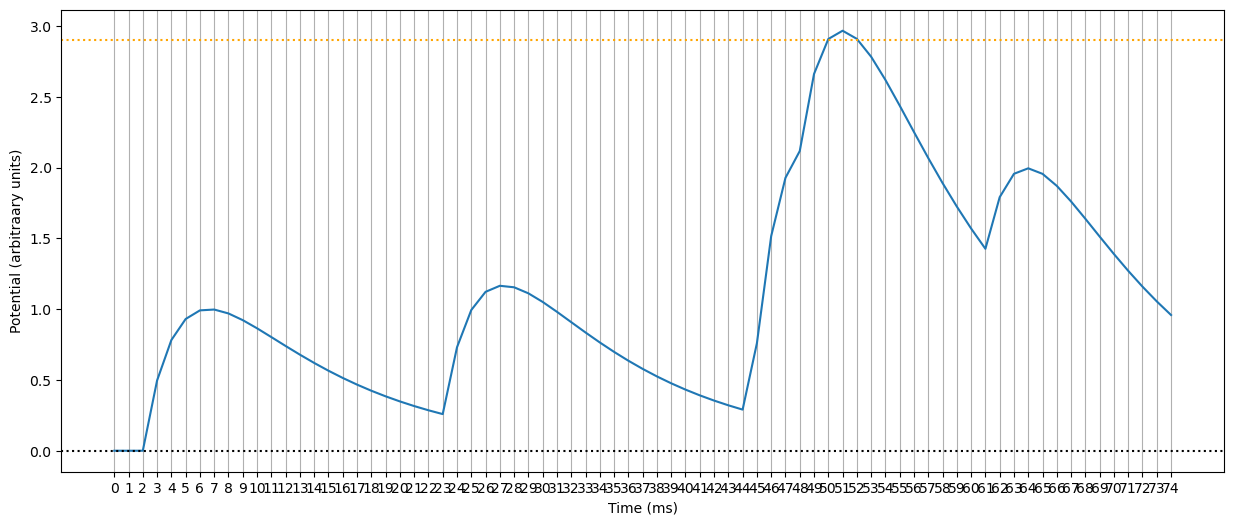

In [121]:
def plot_membrane_potential(potential_rec, threshold):
        plt.figure(figsize=(15,6))
        plt.grid(visible=True, which='major', axis='x')
        plt.xticks(np.arange(0, len(potential_rec), 1))
        plt.plot(np.arange(0,len(potential_rec),1), potential_rec)
        # spikes = np.where(spike_train ==1)[1]
        # for spk in spikes:
            # plt.axvline(spk, linestyle='-.', color='gray')
        plt.axhline(threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')
        plt.show()

plot_membrane_potential(model.potential_rec, 2.9)

In [107]:
def tmp_w_creator(w_j):
    return w[w_j]

vfunc = np.vectorize(tmp_w_creator)
tmp_w = vfunc(spikes_i)
tmp_w


array([1, 5, 1, 5])

In [86]:
dt = 0.001
for it in range(int(spikes_t[-1])+2):
    print(f"at iteration {it}, calculating epsilon for time: {it+1}ms")
    print(spikes_t)
    idx = np.searchsorted(spikes_t, it, side='right')
    print(spikes_t[:idx])
    print(f"idx = {idx}")
    print()


at iteration 0, calculating epsilon for time: 1ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0]
idx = 1

at iteration 1, calculating epsilon for time: 2ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0]
idx = 1

at iteration 2, calculating epsilon for time: 3ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2]
idx = 2

at iteration 3, calculating epsilon for time: 4ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2]
idx = 2

at iteration 4, calculating epsilon for time: 5ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4]
idx = 3

at iteration 5, calculating epsilon for time: 6ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5]
idx = 4

at iteration 6, calculating epsilon for time: 7ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6]
idx = 5

at iteration 7, calculating epsilon for time: 8ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6 7]
idx = 6

at iteration 8, calculating epsilon for time: 9ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6 7]
idx = 6

at iteration 9, calculating epsilon for time: 10m

## Playground

In [16]:
current_t = 4 * dt
spikes_t = np.array([1,  2,  2,  2,  3,  3,  4]) * dt
spikes_i = np.array([0,  0,  1,  2,  1,  2,  2])

weight_example = np.array([[10,11],
                          [20,21],
                          [30,31]], dtype=float)


model = SRM(N=2,
            threshold=2.9,
            reset= 0,
            refractory=0.001, # refractory is a float time [second]
            tau_m=0.010,
            tau_s=0.0025,
            K1=2,
            K2=4,
            window_time= 7 * 0.010, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= True )
model.init_records(time=1)
# model.ref_counter[0,0] = 1

A_pre = 0.3125
B = 0.85 
A_post = - A_pre * B

synapse = Synapse(w=weight_example,
                  w_max=1, # 1
                  w_min=0, # 0
                  A_pre=A_pre,
                  A_post=A_post,
                  tau_pre=0.0168,
                  tau_post=0.0337,
                  approximate=False
                  )
monitor = Monitor(model)

w_tmp = weight_example[spikes_i].squeeze().T
pprint(w_tmp)

potential = model.get_potential(spikes_t, w_tmp, current_t)
potential[1,0] = 0.5
idx = model.check_refractory()
idx_spike = potential >= model.threshold
synapse.a_pre[:, 0] = np.array([0.5, 1, -50])
synapse.a_pre[:, 1] = np.array([-0.5, -10, 20])


print(idx)
print(idx_spike)

idx_spike = idx * idx_spike
print(idx_spike)

pprint(synapse.a_post)
pprint(synapse.w)
synapse.on_post(idx_spike)
pprint(synapse.a_post)
pprint(synapse.a_pre)
pprint(synapse.w)

if monitor:
    monitor.record_spike(current_t, idx_spike)

pprint(monitor.spikes_i)
print(monitor.spikes_t)

model.start_refractory(idx_spike, current_t)
print(model.ref_counter)
model.potential_rec[idx_spike.squeeze(), int(current_t/dt)] = model.eta_kernel(0)
pprint(model.potential_rec)




┌─────────────────────────────┐
 [10.0 10.0 20.0 30.0 20.0 30.0 30.0]
 [11.0 11.0 21.0 31.0 21.0 31.0 31.0]
└─────────────────────────────┘
[[ True]
 [ True]]
[[ True]
 [False]]
[[ True]
 [False]]
┌───────┐
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
└───────┘
┌─────────┐
 [10.0 11.0]
 [20.0 21.0]
 [30.0 31.0]
└─────────┘
┌───────────────┐
 [-0.266 0.0]
 [-0.266 0.0]
 [-0.266 0.0]
└───────────────┘
┌───────────┐
 [0.5   -0.5 ]
 [1.0   -10.0]
 [-50.0 20.0 ]
└───────────┘
┌─────────┐
 [1.0 11.0]
 [1.0 21.0]
 [0.0 31.0]
└─────────┘
[0.]
[0.004]
[[1.]
 [0.]]
┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [113]:
def _examine_post_spike(): 
    w_tmp = weight_example[spikes_i].squeeze().T
    pprint(w_tmp)

    potential = model.get_potential(spikes_t, w_tmp, current_t)
    potential[1,0] = 0.5
    idx = model.check_refractory()
    idx_spike = potential >= model.threshold
    synapse.a_pre[:, 0] = np.array([0.5, 1, -50])
    synapse.a_pre[:, 1] = np.array([-0.5, -10, 20])


    print(idx)
    print(idx_spike)

    idx_spike = idx * idx_spike
    print(idx_spike)

    pprint(synapse.a_post)
    pprint(synapse.w)
    synapse.on_post(idx_spike)
    pprint(synapse.a_post)
    pprint(synapse.a_pre)
    pprint(synapse.w)

    if monitor:
        monitor.record_spike(current_t, idx_spike)

    pprint(monitor.spikes_i)
    print(monitor.spikes_t)

    model.start_refractory(idx_spike)
    print(model.ref_counter)
    model.potential_rec[idx_spike.squeeze(), int(current_t/dt)] = model.eta_kernel(0)
    pprint(model.potential_rec)


_examine_post_spike()

┌────────────────────────────────────┐
 [11.0 11.0 22.0 -70.0 22.0 -70.0 -70.0]
 [11.0 11.0 21.0 31.0  21.0 31.0  31.0 ]
└────────────────────────────────────┘
potential = 
┌────────┐
 [-95.8 ]
 [125.57]
└────────┘
[[ True]
 [ True]]
[[False]
 [False]]
[[False]
 [False]]
┌─────────────┐
 [-0.02 0.0]
 [-0.02 0.0]
 [-0.02 0.0]
└─────────────┘
┌───────────┐
 [11.0  11.0]
 [22.0  21.0]
 [-70.0 31.0]
└───────────┘
┌─────────────┐
 [-0.02 0.0]
 [-0.02 0.0]
 [-0.02 0.0]
└─────────────┘
┌───────────┐
 [0.5   -0.5 ]
 [1.0   -10.0]
 [-50.0 20.0 ]
└───────────┘
┌───────────┐
 [11.0  11.0]
 [22.0  21.0]
 [-70.0 31.0]
└───────────┘
[0. 0.]
[0.004 0.004]
[[0.]
 [0.]]
┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [64]:
def _examine_potential():
    ## At time 4ms and calculating potential at time 5ms. Hence we have + dt
    s = current_t + dt - spikes_t
    eps = model.eps_kernel(s)
    pprint(eps)
    # w_tmp will be given to neuron, calculated by network.
    w_tmp = weight_example[spikes_i].squeeze().T
    w_tmp
    pprint(w_tmp)
    eps = eps * w_tmp
    pprint(eps)
    eps = eps.sum(axis=1, keepdims=True)
    pprint(eps)
    last_spike_time = - np.ones((2,1)) * np.inf
    s = current_t + dt - last_spike_time
    s
    eta = model.eta_kernel(s)
    eta

    pot = eta + eps
    pprint(pot)
    print(pot.shape)

_examine_potential()

[0.99 0.93 0.93 0.93 0.78 0.78 0.5 ]
┌─────────────────────────────┐
 [10.0 10.0 20.0 30.0 20.0 30.0 30.0]
 [11.0 11.0 21.0 31.0 21.0 31.0 31.0]
└─────────────────────────────┘
┌───────────────────────────────────────────┐
 [9.91  9.3   18.61 27.91 15.64 23.46 14.89]
 [10.91 10.24 19.54 28.84 16.42 24.24 15.39]
└───────────────────────────────────────────┘
┌────────┐
 [119.73]
 [125.57]
└────────┘
┌────────┐
 [119.73]
 [125.57]
└────────┘
(2, 1)


In [13]:
pprint(spikes_t, precision=3)
for it in range(7):
    print(f"{it = }")
    idx = np.searchsorted(spikes_t, it*dt, side='right')
    print(f"{idx = }")
    print(spikes_t[:idx])

[0.001 0.002 0.002]
it = 0
idx = 0
[]
it = 1
idx = 1
[0.001]
it = 2
idx = 3
[0.001 0.002 0.002]
it = 3
idx = 3
[0.001 0.002 0.002]
it = 4
idx = 3
[0.001 0.002 0.002]
it = 5
idx = 3
[0.001 0.002 0.002]
it = 6
idx = 3
[0.001 0.002 0.002]


## Final Test

In [4]:
from dev import SRM, InputTrain, Synapse, Network, Monitor
from plotting import plot_input

In [5]:
def get_weights(M, N, initial_val):
    """
    M: number of presynaptic neurons
    N: # postsynaptic neurons
    """
    weight = np.ones((M,N)) * initial_val
    return weight


def plot_potential(start_time, end_time, model, dt, save_path=None):
    patternlength = 0.050
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(start_time,end_time,dt), model.potential_rec[0][int(start_time/dt):int(end_time/dt)])
    plt.axhline(0, linestyle=':', color='black')
    # plt.axhline(model.threshold, linestyle='--', color='red')
    pattern_time = np.where((position_copypaste == 1))[0] * patternlength
    ind = np.where((pattern_time >= start_time) & (pattern_time <= end_time))
    for i in pattern_time[ind]:
        plt.axvspan(i, i + patternlength, facecolor='gray', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane Potential (arbitrary units)')
    if save_path is not None:
        plt.savefig(save_path)

In [27]:
approximate = False
N = 2

dt = 0.001

threshold = 500
reset = 0
refractory = dt
tau_m = 0.010
tau_s = 0.0025
K1 = 2
K2 = 4
window_time= 7 * 0.010, # Maximum time [second] to ignore inputs before it by kernels 
train_mode= True


w_max = 1
w_min = 0
A_pre = 0.3125
B = 0.85
A_post = - A_pre * B
tau_pre=0.0168
tau_post=0.0337

# tau_post=0.0137

weight_initial = get_weights(M=2000, N=N, initial_val=0.475)

weight = weight_initial

# try:
#     weight = synapse.w
# except:
#     weight = weight_initial


In [28]:
spikes_t, spikes_i = times, indices
input_train = InputTrain(spikes_t, spikes_i)

model = SRM(N=N,
            threshold=threshold,
            reset= reset,
            refractory=refractory, # refractory is a float time [second]
            tau_m=tau_m,
            tau_s=tau_s,
            K1=K1,
            K2=K2,
            window_time= window_time, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= train_mode)


synapse = Synapse(w=weight,
                  w_max=w_max,
                  w_min=w_min,
                  A_pre=A_pre,
                  A_post=A_post,
                  tau_pre=tau_pre,
                  tau_post=tau_post,
                  approximate= approximate
                  )
monitor = Monitor(model)

net = Network()

net.add_input_train(input_train)
net.add_layer(model)
net.add_synapse(synapse)

In [29]:
# time must be ms
TIME = int(450 * 1000)
net.run(time=TIME)

it = 0
it = 20000
it = 40000
it = 60000
it = 80000
it = 100000
it = 120000
it = 140000
it = 160000
it = 180000
it = 200000
it = 220000
it = 240000
it = 260000
it = 280000
it = 300000
it = 320000
it = 340000
it = 360000
it = 380000
it = 400000
it = 420000
it = 440000


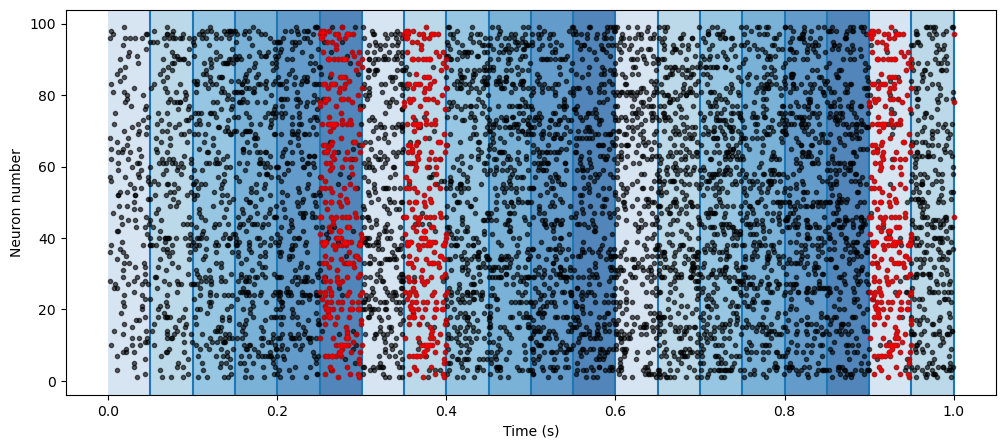

In [30]:
params = {'start_time' : 0.0,
        'end_time' : 1.0,
        'start_index' : 0,
        'end_index' : 100,}

plot_input(times, indices, params, times_pattern, indices_pattern)

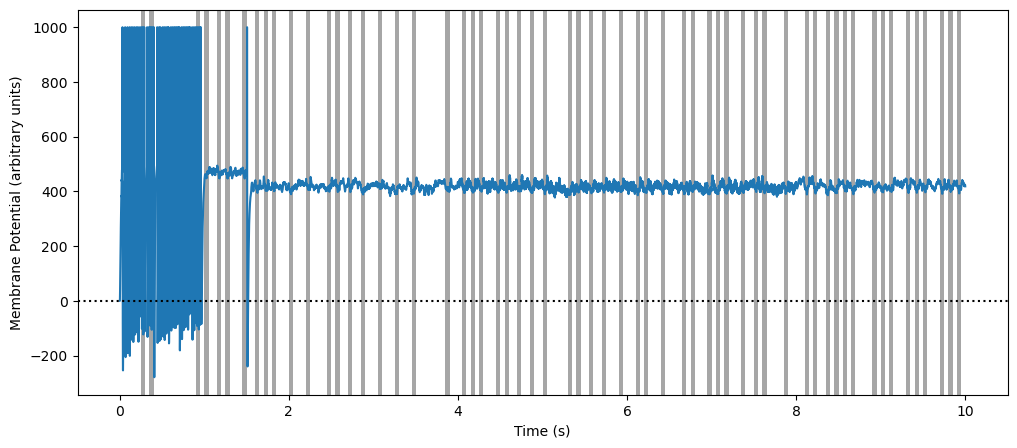

In [37]:
start_time = 0
end_time = 10

model.potential_rec[0][int(start_time/dt):int(end_time/dt)]


plot_potential(start_time, end_time, model, dt)

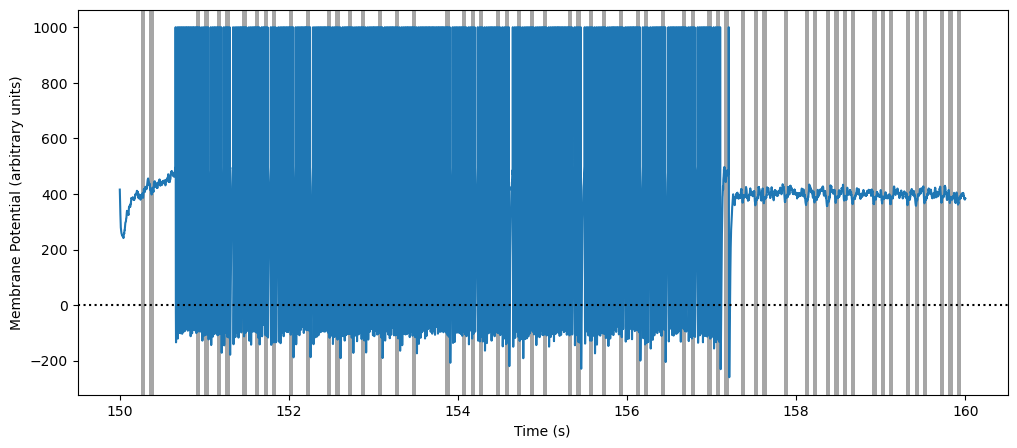

In [39]:
start_time = 150
end_time = 160

model.potential_rec[0][int(start_time/dt):int(end_time/dt)]


plot_potential(start_time, end_time, model, dt)

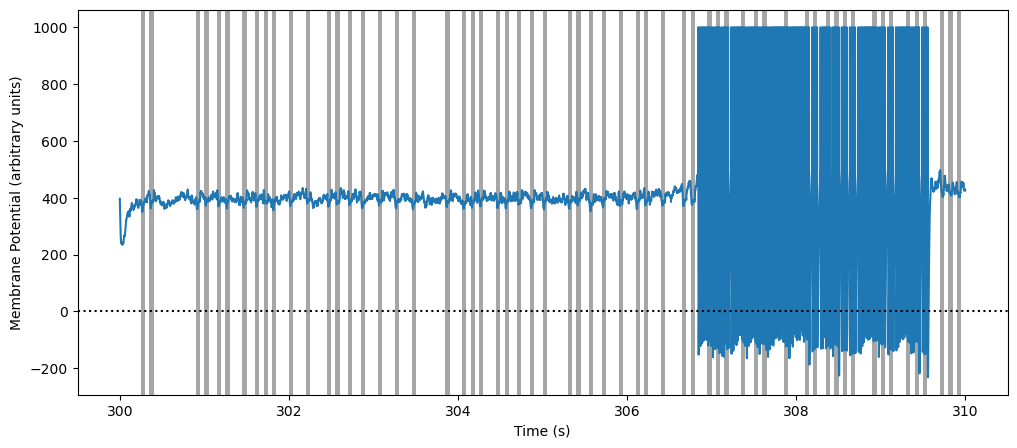

In [38]:
start_time = 300
end_time = 310

model.potential_rec[0][int(start_time/dt):int(end_time/dt)]


plot_potential(start_time, end_time, model, dt)

In [14]:
# model.potential_rec[0,:10]
pprint(synapse.a_pre[:20,0])

pprint(synapse.a_post[:20,0])

[0.019 0.294 0.244 0.169 0.191 0.044 0.06  0.053 0.014 0.169 0.092 0.216
 0.216 0.03  0.047 0.294 0.23  0.056 0.294 0.26 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


active neuron ration (w > 0.7): 9.3%


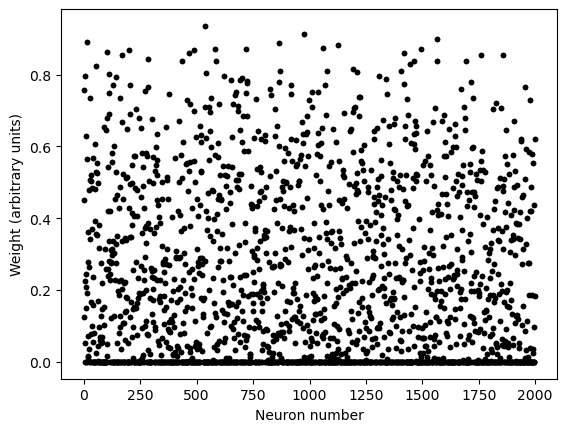

In [40]:
active_ration = np.sum(weight>0.7)/ len(weight) * 100
print(f'active neuron ration (w > 0.7): {active_ration:.1f}%')
plt.plot(np.arange(len(weight)), synapse.w, '.k')
plt.xlabel('Neuron number')
plt.ylabel('Weight (arbitrary units)')
plt.show()

In [26]:
del synapse
del net
del model